In [1]:
import os; os.chdir('..')
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from transformers import GPT2LMHeadModel

from utils import *; from boring_utils.utils import *

init_graph()
device = get_device()

In [2]:
# since we gonna do some visualization, let's put it on cpu
model_hf = GPT2LMHeadModel.from_pretrained("gpt2")
# model_hf = GPT2LMHeadModel.from_pretrained('distilgpt2')
sd_hf = model_hf.state_dict()

for k, v in sd_hf.items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

# PE

In [3]:
sd_hf["transformer.wpe.weight"].view(-1)[:20]

tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
        -0.0491, -0.0565, -0.0025,  0.0135, -0.0042,  0.0151,  0.0166, -0.1381,
        -0.0063, -0.0461,  0.0267, -0.2042])

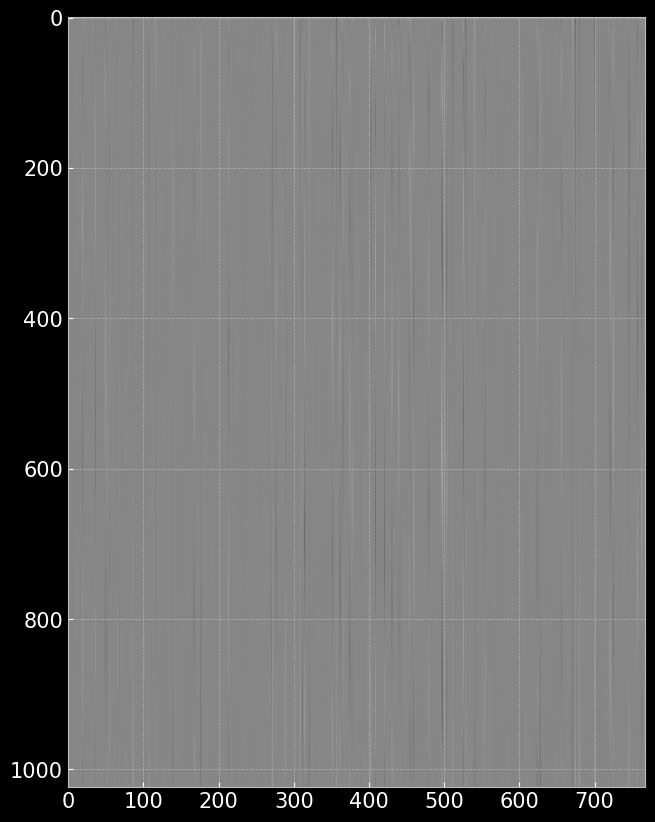

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")

preview channel at x axis (learned instead of sin/cos)

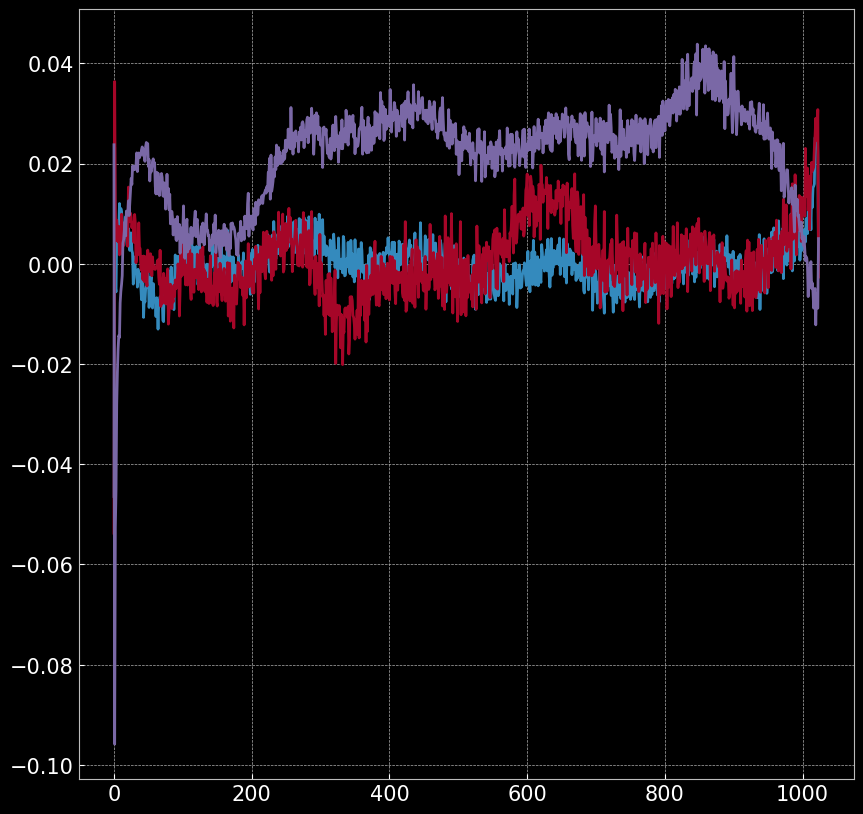

In [5]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 150])
plt.plot(sd_hf["transformer.wpe.weight"][:, 200])
plt.plot(sd_hf["transformer.wpe.weight"][:, 250])

# Attn Weights

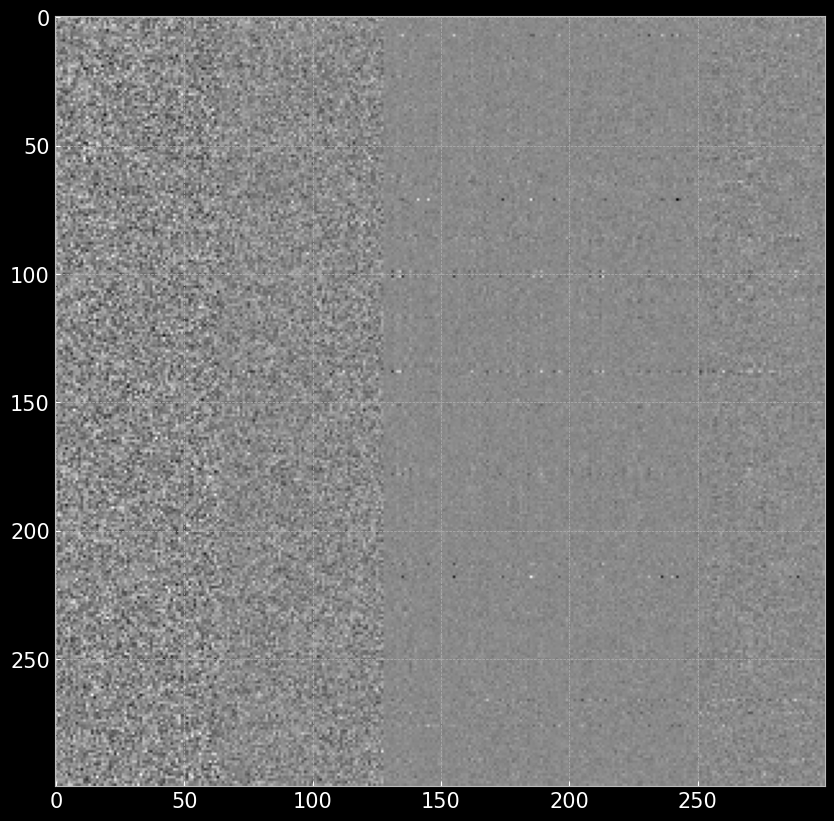

In [6]:
plt.imshow(sd_hf["transformer.h.1.attn.c_attn.weight"][:300,:300], cmap="gray")

# Test Gen

In [7]:
from transformers import pipeline, set_seed
set_seed(42)

# generator = pipeline('text-generation', model='gpt2')
# generator("Hello, I'm a smart language model,", max_length=30, num_return_sequences=5)

In [8]:
# generator = pipeline('text-generation', model='gpt2')
# generator("Hello, I'm a dumb language model,", max_length=30, num_return_sequences=5)

In [9]:
generator = pipeline('text-generation', model='gpt2')
generator("Hello, I'm a horny language model,", max_length=30, num_return_sequences=5)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a horny language model, but what I'm really doing is making myself a little more aware of being a porn star, and I"},
 {'generated_text': "Hello, I'm a horny language model, this is not the best thing I've done in my life, and most likely I wouldn't even be"},
 {'generated_text': 'Hello, I\'m a horny language model, and you\'ll hear me playing some of those weird music."\n\n"Are you talking to that kind'},
 {'generated_text': 'Hello, I\'m a horny language model, you know." she says.\n\n"Why, you\'re my number one fan!" The audience cheers'},
 {'generated_text': "Hello, I'm a horny language model, I've been married 17 times and lost two of them. This makes me sad because even though it's"}]

In [10]:
# generator = pipeline('text-generation', model='gpt2')
# generator("Hello, I'm a dumb language model, and I am gonna taking over the world, and", max_length=30, num_return_sequences=5)

# Manual Sample

In [11]:
# let's instead sample manually
import torch
from torch.nn import functional as F

model = GPT2LMHeadModel.from_pretrained("gpt2")  # 124M
model.eval()
model.to(device)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
tokens = [15496, 11, 314, 1101, 257, 3303, 2746, 11]  # "Hello, I'm a language model,"
tokens = torch.tensor(tokens, dtype=torch.long)  # (8,)
tokens = tokens.unsqueeze(0).repeat(5, 1)  # (5, 8)
x = tokens.to(device)

# generate!
while x.size(1) < 30: # max_length=30
    # forward the model to get the logits
    with torch.no_grad():
        logits = model(x)[0] # (B, T, vocab_size)
        # take the logits at the last position
        logits = logits[:, -1, :] # (B, vocab_size)
        # get the probabilities
        probs = F.softmax(logits, dim=-1)
        # do top-k sampling of 50 (huggingface pipeline default)
        # topk_probs here becomes (5, 50), topk_indices is (5, 50)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        # select a token from the top-k probabilities
        # note: multinomial does not demand the input to sum to 1
        ix = torch.multinomial(topk_probs, 1) # (B, 1)
        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        # append to the sequence
        x = torch.cat((x, xcol), dim=1)

# print the generated text
import tiktoken
enc = tiktoken.get_encoding('gpt2')
for i in range(5):
    tokens = x[i, :30].tolist()
    decoded = enc.decode(tokens)
    print(">", decoded)

> Hello, I'm a language model, not a program.

So this morning I started studying for the interview in the lab. This was not
> Hello, I'm a language model, and one of the main things that bothers me when they create languages is how easy it becomes to create something that
> Hello, I'm a language model, and I wrote it off on the grounds that a language model would make me more fluent. But I'm not
> Hello, I'm a language model, I really like languages. I like languages because like, they're good. And the way we talk about languages
> Hello, I'm a language model, a language model I'm using for data modelling. All I did was test the results and then I wrote some
